In [848]:
import shap
import sys
import importlib
sys.path.append('/home/robbe/IM2DeepMulti')
sys.path.append('/home/robbe/IM2DeepMulti/IM2DeepMulti')
from datetime import datetime
from IM2DeepMulti.models import IM2DeepMultiTransferWithAttention, IM2DeepMultiTransfer
import IM2DeepMulti.utils
importlib.reload(IM2DeepMulti)

import numpy as np
import pickle
from torch.utils.data import DataLoader, TensorDataset
import torch
import matplotlib.pyplot as plt
import seaborn as sns


In [849]:
# C_comp, H_comp, N_comp, O_comp,
#S_comp, P_comp, length, Rel_H presence,
#Rel_Bulky presence, Rel_Acid presence, Rel_KR_presence, charge, 6 x 8 atom counts of first four and last four AA
global_feature_list = [
    'SumC',
    'SumH',
    'SumN',
    'SumO',
    'SumS',
    'SumP',
    'SeqLen',
    'Rel_H',
    'Rel_Bulky',
    'Rel_Acid',
    'Rel_KR',
    'Charge',
    'SumC1',
    'SumH1',
    'SumN1',
    'SumO1',
    'SumS1',
    'SumP1',
    'SumC2',
    'SumH2',
    'SumN2',
    'SumO2',
    'SumS2',
    'SumP2',
    'SumC3',
    'SumH3',
    'SumN3',
    'SumO3',
    'SumS3',
    'SumP3',
    'SumC4',
    'SumH4',
    'SumN4',
    'SumO4',
    'SumS4',
    'SumP4',
    'SumC-4',
    'SumH-4',
    'SumN-4',
    'SumO-4',
    'SumS-4',
    'SumP-4',
    'SumC-3',
    'SumH-3',
    'SumN-3',
    'SumO-3',
    'SumS-3',
    'SumP-3',
    'SumC-2',
    'SumH-2',
    'SumN-2',
    'SumO-2',
    'SumS-2',
    'SumP-2',
    'SumC-1',
    'SumH-1',
    'SumN-1',
    'SumO-1',
    'SumS-1',
    'SumP-1',
]

In [850]:
# torch.manual_seed(1234)
# np.random.seed(1234)

# Prepare model and data

In [851]:
# Current best model
config = {
    "name": "BestPearsonBestModel",
    "time": datetime.now().strftime("%Y-%m-%d_%H-%M-%S"),
    "batch_size": 32,
    "learning_rate": 0.0000885185503354955,
    "diversity_weight": 1.2631492541307987,    # Should be high when using FlexibleLoss (4.2), much lower when using FlexibleLossSorted (1)
    "L1_alpha": 0.00000043707211872154, #0.00003 for FlexibleLoss, 0.02 for FlexibleLossSorted
    "epochs": 300,
    "delta": 0,
    "device": "1",
    "Use_best_model": 1,
    "Add_branch_layer": 0,
    'BranchSize': 28, #64 seems to be the best
    'Loss_type': 'FlexibleLoss',
    'Use_attention_output': 1,
    'Use_attention_concat': 1,
}

In [852]:
criterion = IM2DeepMulti.utils.FlexibleLoss(config['diversity_weight'])
best_model = IM2DeepMultiTransferWithAttention.load_from_checkpoint('/home/robbe/IM2DeepMulti/checkpoints/BestModelAdaptedToNewArch.ckpt', config=config, criterion=criterion)

1335
480
20
6
1841


In [853]:
device = torch.device("cpu")

In [854]:
# Train
ccs_df_train = pickle.load(open('/home/robbe/IM2DeepMulti/data/ccs_df_train_OnlyMoreMultimodals.pkl', 'rb'))
Train_AtomEnc = pickle.load(open("/home/robbe/IM2DeepMulti/data/X_train_AtomEnc-OnlyMoreMultimodals.pickle", "rb"))
Train_Globals = pickle.load(
    open("/home/robbe/IM2DeepMulti/data/X_train_GlobalFeatures-OnlyMoreMultimodals.pickle", "rb")
)
Train_DiAminoAtomEnc = pickle.load(open('/home/robbe/IM2DeepMulti/data/X_train_DiAminoAtomEnc-OnlyMoreMultimodals.pickle', 'rb'))
Train_OneHot = pickle.load(open('/home/robbe/IM2DeepMulti/data/X_train_OneHot-OnlyMoreMultimodals.pickle', 'rb'))
y_train = pickle.load(open('/home/robbe/IM2DeepMulti/data/y_train-OnlyMoreMultimodals.pickle', 'rb'))

y_train = np.vstack(y_train)
print(y_train.shape)
Train_AtomEnc = torch.tensor(Train_AtomEnc, dtype=torch.float32)
Train_Globals = torch.tensor(Train_Globals, dtype=torch.float32)
Train_DiAminoAtomEnc = torch.tensor(Train_DiAminoAtomEnc, dtype=torch.float32)
Train_OneHot = torch.tensor(Train_OneHot, dtype=torch.float32)
y_train = torch.tensor(y_train)
train_dataset = TensorDataset(Train_AtomEnc, Train_DiAminoAtomEnc, Train_Globals, Train_OneHot, y_train)
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True, num_workers=16)

# Test
ccs_df_test = pickle.load(open('/home/robbe/IM2DeepMulti/data/ccs_df_test_OnlyMoreMultimodals.pkl', 'rb'))
Test_AtomEnc = pickle.load(open("/home/robbe/IM2DeepMulti/data/X_test_AtomEnc-OnlyMoreMultimodals.pickle", "rb"))
Test_Globals = pickle.load(
    open("/home/robbe/IM2DeepMulti/data/X_test_GlobalFeatures-OnlyMoreMultimodals.pickle", "rb")
)
Test_DiAminoAtomEnc = pickle.load(open('/home/robbe/IM2DeepMulti/data/X_test_DiAminoAtomEnc-OnlyMoreMultimodals.pickle', 'rb'))
Test_OneHot = pickle.load(open('/home/robbe/IM2DeepMulti/data/X_test_OneHot-OnlyMoreMultimodals.pickle', 'rb'))
y_test = pickle.load(open('/home/robbe/IM2DeepMulti/data/y_test-OnlyMoreMultimodals.pickle', 'rb'))

y_test = np.vstack(y_test)
print(y_test.shape)
Test_AtomEnc = torch.tensor(Test_AtomEnc, dtype=torch.float32)
Test_Globals = torch.tensor(Test_Globals, dtype=torch.float32)
Test_DiAminoAtomEnc = torch.tensor(Test_DiAminoAtomEnc, dtype=torch.float32)
Test_OneHot = torch.tensor(Test_OneHot, dtype=torch.float32)
y_test = torch.tensor(y_test)
test_dataset = TensorDataset(Test_AtomEnc, Test_DiAminoAtomEnc, Test_Globals, Test_OneHot, y_test)
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False, num_workers=16)

(7922, 2)
(881, 2)


# Captum

In [855]:
from captum.attr import IntegratedGradients, GradientShap, KernelShap, DeepLiftShap, FeatureAblation

In [856]:
best_model.eval()
best_model.to(device)

IM2DeepMultiTransferWithAttention(
  (criterion): FlexibleLoss()
  (backbone): IM2Deep(
    (ConvAtomComp): ModuleList(
      (0): Conv1d(6, 356, kernel_size=(4,), stride=(1,), padding=same)
      (1): LRelu_with_saturation(
        (leaky_relu): LeakyReLU(negative_slope=0.013545684190756122)
      )
      (2): Conv1d(356, 356, kernel_size=(4,), stride=(1,), padding=same)
      (3): LRelu_with_saturation(
        (leaky_relu): LeakyReLU(negative_slope=0.013545684190756122)
      )
      (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv1d(356, 178, kernel_size=(4,), stride=(1,), padding=same)
      (6): LRelu_with_saturation(
        (leaky_relu): LeakyReLU(negative_slope=0.013545684190756122)
      )
      (7): Conv1d(178, 178, kernel_size=(4,), stride=(1,), padding=same)
      (8): LRelu_with_saturation(
        (leaky_relu): LeakyReLU(negative_slope=0.013545684190756122)
      )
      (9): MaxPool1d(kernel_size=2, stride=2, padding=0, dil

In [857]:
ig = IntegratedGradients(best_model)
gs = GradientShap(best_model)
ks = KernelShap(best_model)
ds = DeepLiftShap(best_model)
fa = FeatureAblation(best_model)

In [858]:
# fa_attr_test_0 = fa.attribute((Test_AtomEnc.to(device), Test_DiAminoAtomEnc.to(device), Test_Globals.to(device), Test_OneHot.to(device)), target=0, n_samples=100)
# fa_attr_test_1 = fa.attribute((Test_AtomEnc.to(device), Test_DiAminoAtomEnc.to(device), Test_Globals.to(device), Test_OneHot.to(device)), target=1, n_samples=100)

In [859]:
# Save the attributions to pickle
pickle.dump(fa_attr_test_0, open('/home/robbe/IM2DeepMulti/data/fa_attr_test_0_OnlyMoreMultimodals.pickle', 'wb'))
pickle.dump(fa_attr_test_1, open('/home/robbe/IM2DeepMulti/data/fa_attr_test_1_OnlyMoreMultimodals.pickle', 'wb'))

In [860]:
fa_attr_test_0 = pickle.load(open('/home/robbe/IM2DeepMulti/data/fa_attr_test_0_OnlyMoreMultimodals.pickle', 'rb'))
fa_attr_test_1 = pickle.load(open('/home/robbe/IM2DeepMulti/data/fa_attr_test_1_OnlyMoreMultimodals.pickle', 'rb'))

In [861]:
len(fa_attr_test_0)

4

In [862]:
atomEnc1 = fa_attr_test_0[0].detach().cpu().numpy()
atomEnc2 = fa_attr_test_1[0].detach().cpu().numpy()
diAminoEnc1 = fa_attr_test_0[1].detach().cpu().numpy()
diAminoEnc2 = fa_attr_test_1[1].detach().cpu().numpy()
global1 = fa_attr_test_0[2].detach().cpu().numpy()
global2 = fa_attr_test_1[2].detach().cpu().numpy()
oneHot1 = fa_attr_test_0[3].detach().cpu().numpy()
oneHot2 = fa_attr_test_1[3].detach().cpu().numpy()

# Atom Enc

In [863]:
# Mean over all samples
atomEnc1mean = np.mean(atomEnc1, axis=0)
atomEnc2mean = np.mean(atomEnc2, axis=0)

In [864]:
# Function to standardize an array
def standardize(array):
    mask = array != 0
    mean = array.mean()
    std = array.std()
    standardized_array = np.where(mask, (array - mean) / std, 0)
    return standardized_array

In [865]:
# Standardize the arrays
atomEnc1mean = standardize(atomEnc1mean.reshape(-1, 1))
atomEnc2mean = standardize(atomEnc2mean.reshape(-1, 1))

#Reshape back to 60,6
atomEnc1mean = atomEnc1mean.reshape(60, 6)
atomEnc2mean = atomEnc2mean.reshape(60, 6)

# Everything beyond (50,5) is 0, so we can remove it
atomEnc1mean = atomEnc1mean[:52, :5]
atomEnc2mean = atomEnc2mean[:52, :5]

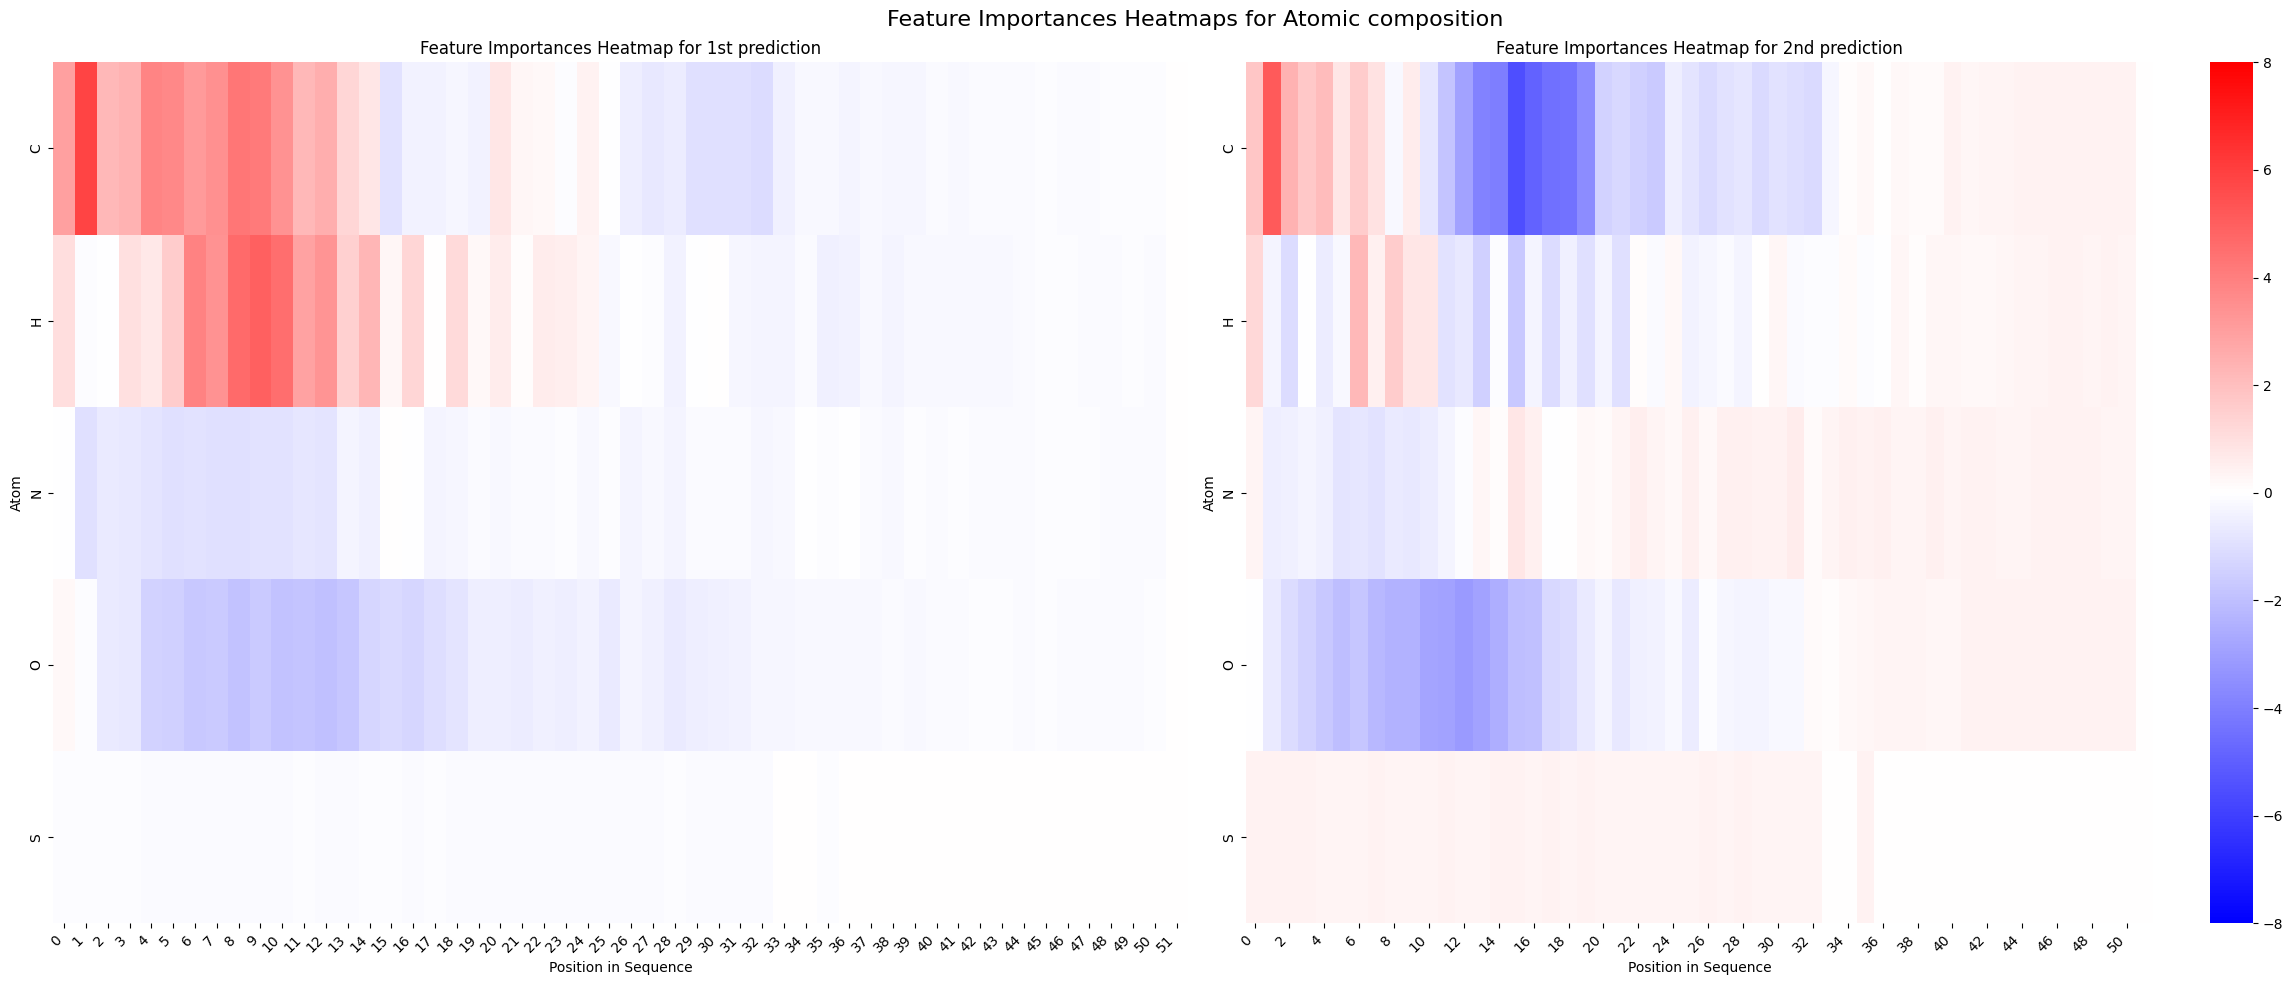

In [866]:
# Setup for side-by-side plotting

fig, axs = plt.subplots(ncols=2, figsize=(24, 10))  # Create two columns for subplots

# Use spectral colormap
cmap = sns.color_palette("bwr", as_cmap=True)

vmin = min(-8,8)
vmax = max(-8,8)


# Transpose the SHAP values matrices to invert axes and mask zeros
shap_values_output1_masked = np.ma.masked_where(atomEnc1mean == 0., atomEnc1mean)
shap_values_output2_masked = np.ma.masked_where(atomEnc2mean == 0., atomEnc2mean)

# Create a heatmap for the first output
sns.heatmap(shap_values_output1_masked.T, ax=axs[0], annot=False, cmap=cmap, fmt=".2f", linewidths=.001, cbar=False, vmin=vmin, vmax=vmax, rasterized=False, linecolor='gray')
axs[0].set_title('Feature Importances Heatmap for 1st prediction')
axs[0].set_xlabel('Position in Sequence')
axs[0].set_ylabel('Atom')
axs[0].set_yticklabels(['C', 'H', 'N', 'O', 'S'])

# Create a heatmap for the second output
sns.heatmap(shap_values_output2_masked.T, ax=axs[1], annot=False, cmap=cmap, fmt=".2f", linewidths=.001, cbar=True, vmin=vmin, vmax=vmax, rasterized=False, linecolor='gray')
axs[1].set_title('Feature Importances Heatmap for 2nd prediction')
axs[1].set_xlabel('Position in Sequence')
axs[1].set_ylabel('Atom')
axs[1].set_yticklabels(['C', 'H', 'N', 'O', 'S'])
# Rotate x-axis labels
plt.setp(axs[0].get_xticklabels(), rotation=45, ha='right')
plt.setp(axs[1].get_xticklabels(), rotation=45, ha='right')
# Define x-axis label frequency and show labels

plt.suptitle('Feature Importances Heatmaps for Atomic composition', fontsize=16)
plt.tight_layout()  # Adjust layout to not overlap
plt.show()


# DiAA Atom Enc

In [867]:
# Mean over all samples
diAminoEnc1mean = np.mean(diAminoEnc1, axis=0)
diAminoEnc2mean = np.mean(diAminoEnc2, axis=0)

In [868]:
# Scale
diAminoEnc1mean = standardize(diAminoEnc1mean.reshape(-1, 1))
diAminoEnc2mean = standardize(diAminoEnc2mean.reshape(-1, 1))

# Reshape back to 30,6
diAminoEnc1mean = diAminoEnc1mean.reshape(30, 6)
diAminoEnc2mean = diAminoEnc2mean.reshape(30, 6)

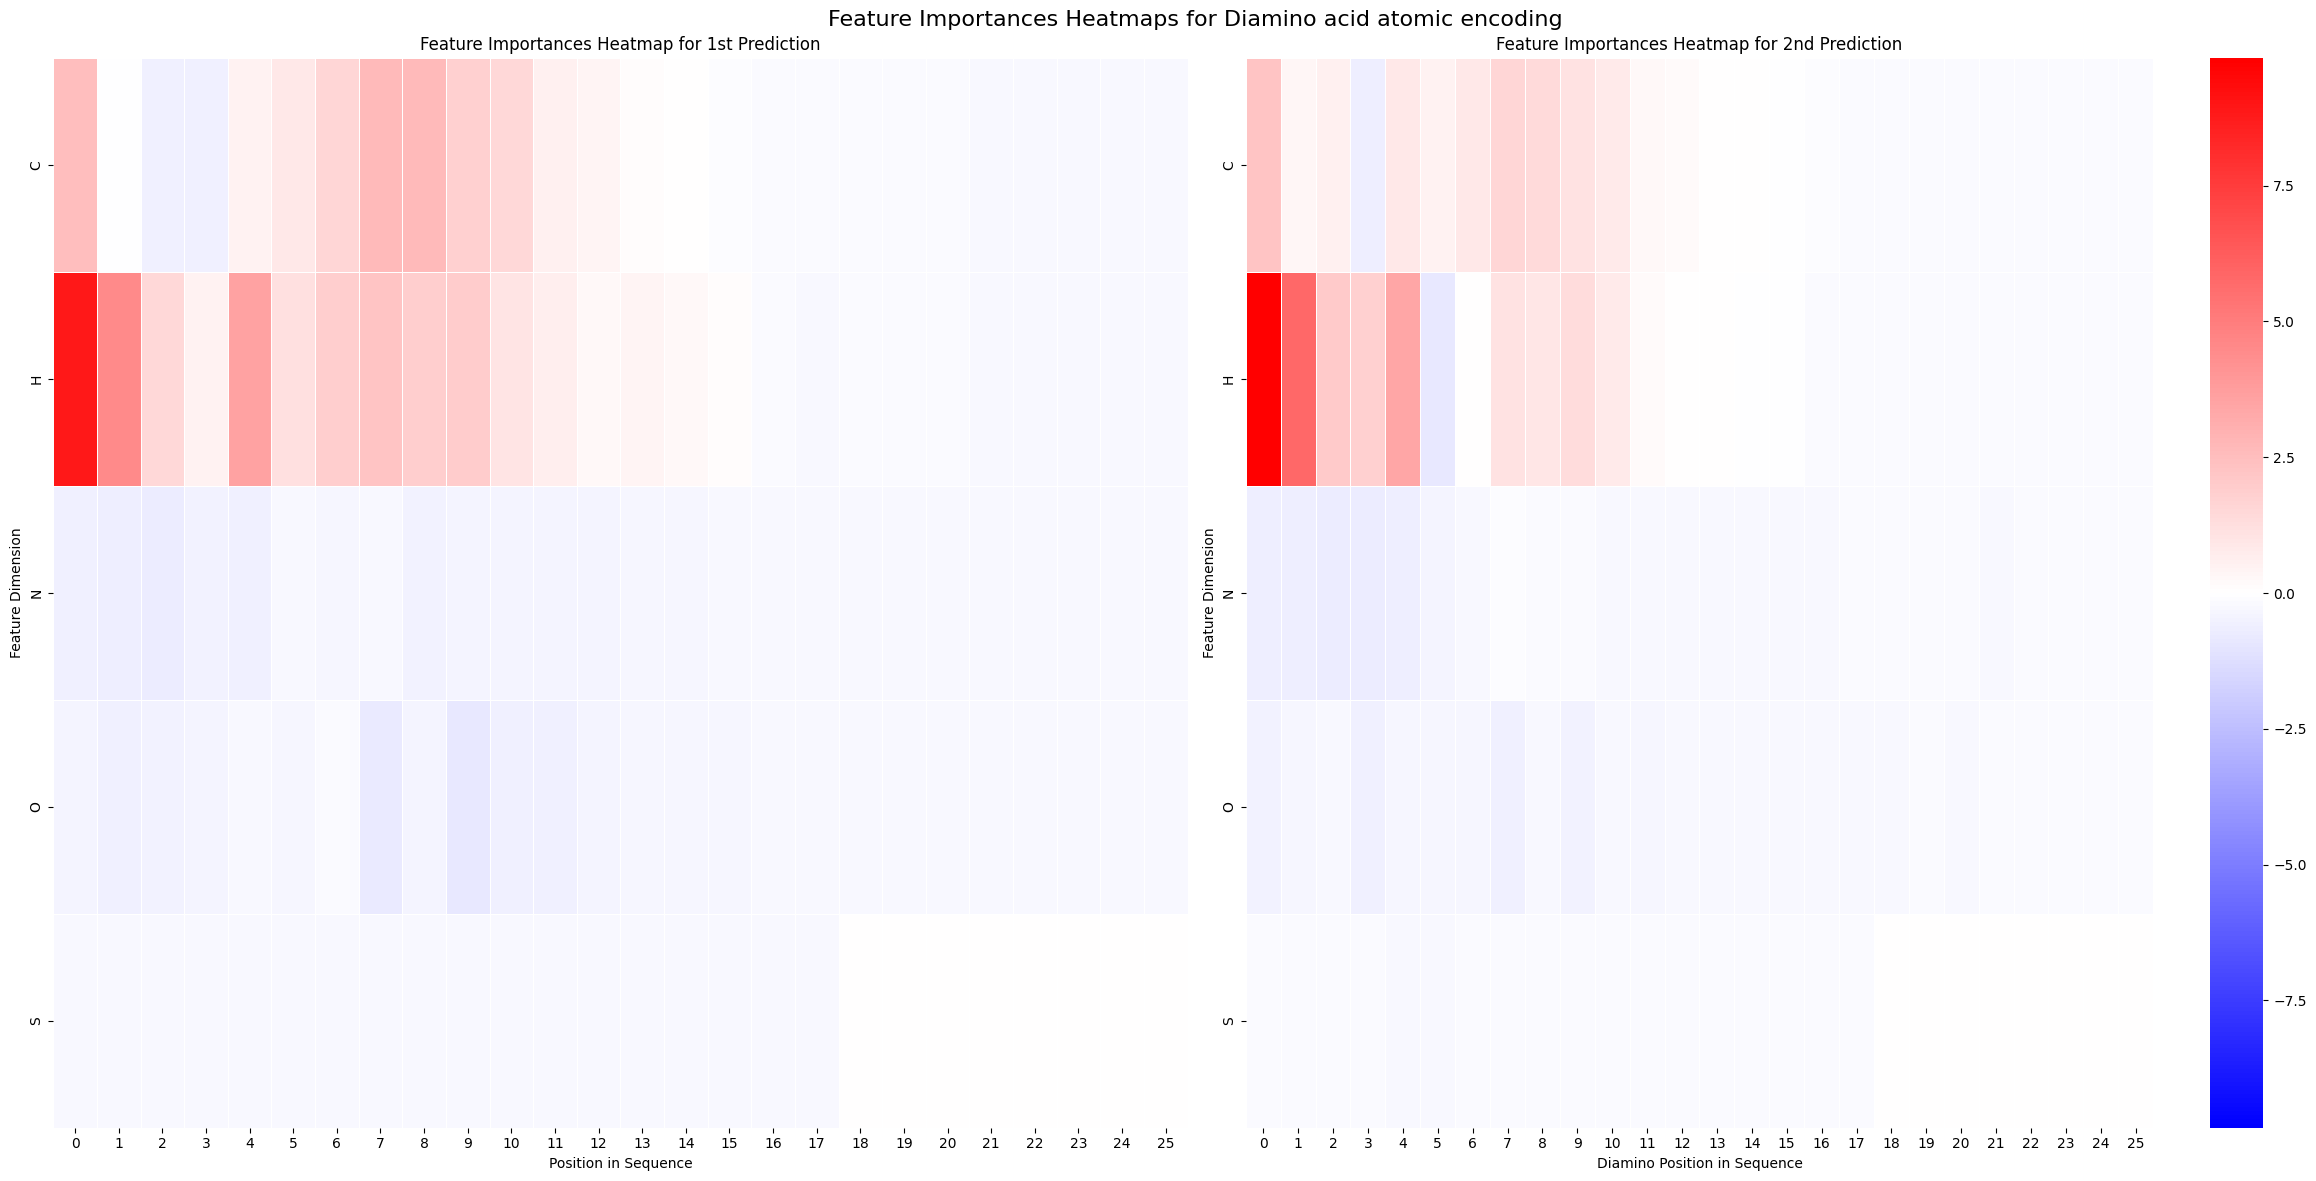

In [869]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Everything past (19, 5) is 0, so we can remove it
diAminoEnc1mean = diAminoEnc1mean[:26, :5]
diAminoEnc2mean = diAminoEnc2mean[:26, :5]

# Setup for side-by-side plotting
fig, axs = plt.subplots(ncols=2, figsize=(24, 12))  # Adjust size as needed

# Use a blue-red colormap which is good for diverging data
cmap = sns.color_palette("bwr", as_cmap=True)

# Define vmin and vmax for color scaling based on the maximum absolute value in both matrices
vmin, vmax = -np.max(np.abs([diAminoEnc1mean, diAminoEnc2mean])), np.max(np.abs([diAminoEnc1mean, diAminoEnc2mean]))

# Mask zeros for visualization clarity
shap_values_output1_masked = np.ma.masked_where(diAminoEnc1mean == 0, diAminoEnc1mean)
shap_values_output2_masked = np.ma.masked_where(diAminoEnc2mean == 0, diAminoEnc2mean)

# Create a heatmap for the first output
sns.heatmap(shap_values_output1_masked.T, ax=axs[0], annot=False, cmap=cmap, fmt=".2f", linewidths=.5, cbar=False, vmin=vmin, vmax=vmax)
axs[0].set_title('Feature Importances Heatmap for 1st Prediction')
axs[0].set_xlabel('Position in Sequence')
axs[0].set_ylabel('Feature Dimension')
# Update yticklabels if you have specific labels for the dimensions
axs[0].set_yticklabels(['C', 'H', 'N', 'O', 'S'])

# Create a heatmap for the second output
sns.heatmap(shap_values_output2_masked.T, ax=axs[1], annot=False, cmap=cmap, fmt=".2f", linewidths=.5, cbar=True, vmin=vmin, vmax=vmax)
axs[1].set_title('Feature Importances Heatmap for 2nd Prediction')
axs[1].set_xlabel('Diamino Position in Sequence')
axs[1].set_ylabel('Feature Dimension')
axs[1].set_yticklabels(['C', 'H', 'N', 'O', 'S'])

plt.suptitle('Feature Importances Heatmaps for Diamino acid atomic encoding', fontsize=16)
plt.tight_layout()  # Adjust layout to not overlap
plt.show()


# Globals

In [870]:
# Mean over all samples
global1mean = np.mean(global1, axis=0)
global2mean = np.mean(global2, axis=0)

In [871]:
# Scale
global1mean = standardize(global1mean)
global2mean = standardize(global2mean)

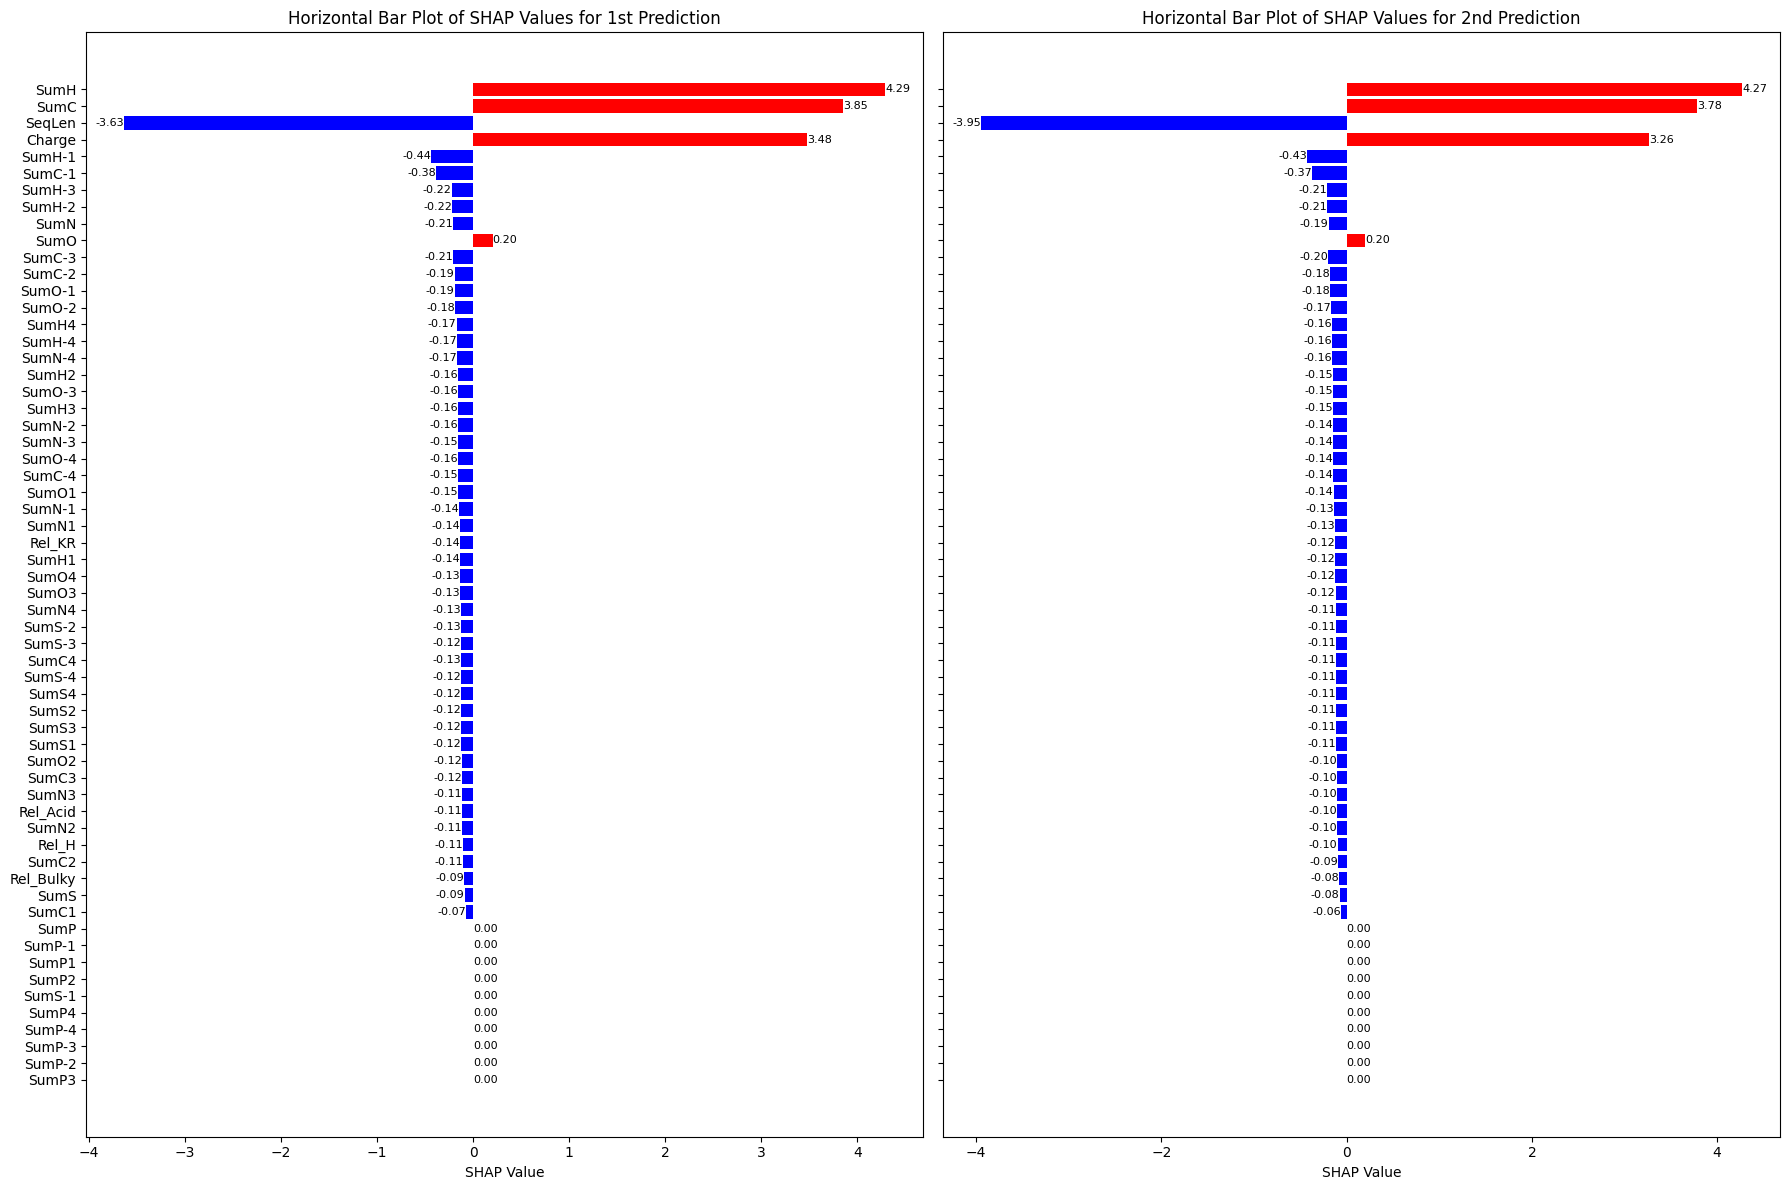

In [872]:
# Generate labels for the features
features = global_feature_list

def create_bar_plot(shap_values, title, ax, feature_order):
    # Use the pre-determined feature order
    sorted_features = [features[i] for i in feature_order]
    sorted_values = shap_values[feature_order]

    # Assign colors based on the value being positive or negative
    colors = ['red' if x > 0 else 'blue' for x in sorted_values]

    # Creating the bar plot
    bars = ax.barh(sorted_features, sorted_values, color=colors)
    ax.set_title(title)
    ax.set_xlabel('SHAP Value')
    ax.invert_yaxis()  # Invert y-axis to align both plots with the same order from top to bottom

    # Annotate bars with the SHAP values
    for bar, value in zip(bars, sorted_values):
        ax.text(value, bar.get_y() + bar.get_height()/2, '%.2f' % value,
                va='center', ha='right' if value < 0 else 'left', color='black', fontsize=8)

# Determine a uniform order for the features; sort by the absolute values of the combined outputs
combined_shap = np.abs(global1mean) + np.abs(global2mean)
feature_order = np.argsort(combined_shap)

# Setup plots next to each other
fig, axs = plt.subplots(ncols=2, figsize=(18, 12), sharey=True)

# Generate horizontal bar plots
create_bar_plot(global1mean, 'Horizontal Bar Plot of SHAP Values for 1st Prediction', axs[0], feature_order)
create_bar_plot(global2mean, 'Horizontal Bar Plot of SHAP Values for 2nd Prediction', axs[1], feature_order)

plt.tight_layout()
plt.show()


# OneHot

In [873]:
aa_list = ["K", "R", "P","T","N","A","Q","V","S","G","I","L","C","M","H","F","Y","W","E","D"]

In [874]:
# Mean over all samples
oneHot1mean = np.mean(oneHot1, axis=0)
oneHot2mean = np.mean(oneHot2, axis=0)

In [875]:
# Scale
oneHot1mean = standardize(oneHot1mean.reshape(-1, 1))
oneHot2mean = standardize(oneHot2mean.reshape(-1, 1))

# Reshape back to 20,60
oneHot1mean = oneHot1mean.reshape(60, 20)
oneHot2mean = oneHot2mean.reshape(60, 20)

(30, 20)
(30, 20)


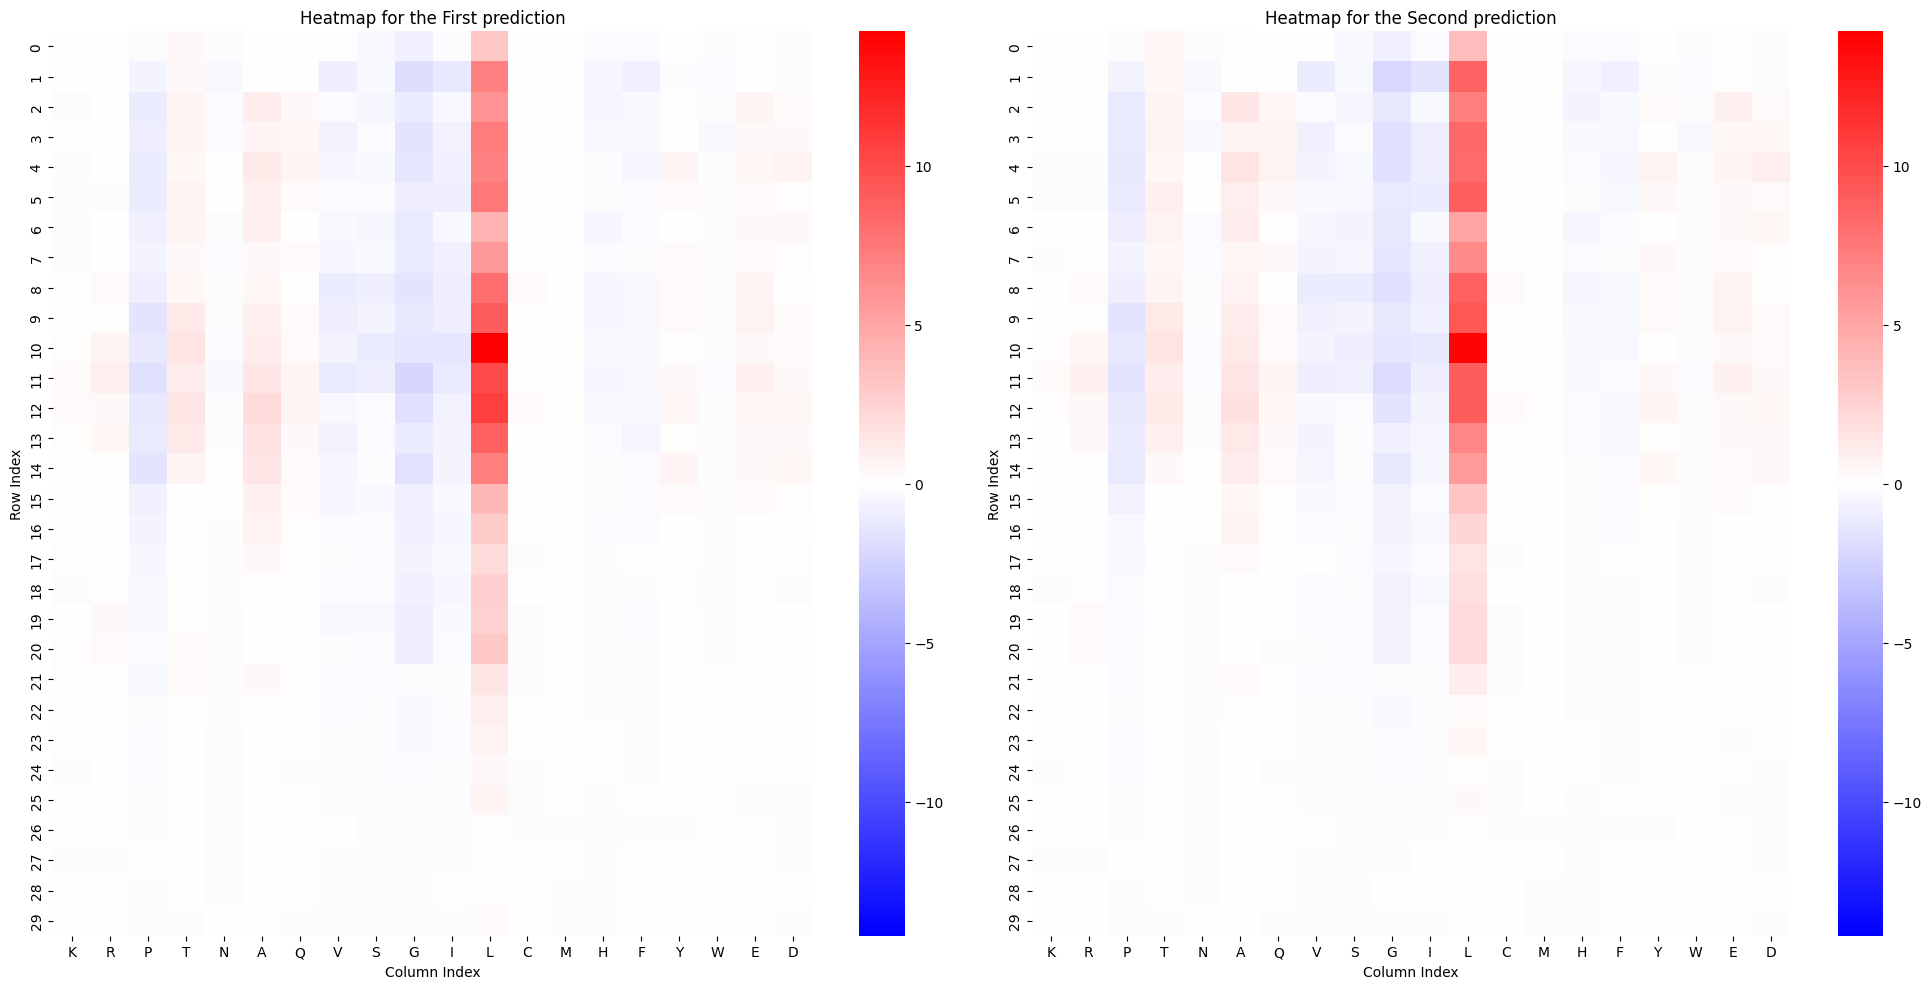

In [876]:
#Everything past position 34 is 0, so we can remove it
oneHot1mean = oneHot1mean[:30, :]
oneHot2mean = oneHot2mean[:30, :]

# Assuming `data1` and `data2` are your numpy arrays of shape (60, 20) for the first and second outputs
data1 = oneHot1mean  # Replace with your actual data array for the first output
data2 = oneHot2mean  # Replace with your actual data array for the second output
print(data1.shape)
print(data2.shape)

cmap = sns.color_palette("bwr", as_cmap=True)
vmin, vmax = -np.max(np.abs([data1, data2])), np.max(np.abs([data1, data2]))

# Create a figure and a set of subplots
fig, axs = plt.subplots(ncols=2, figsize=(20, 10))  # Adjust size to your liking

# Heatmap for the first data set
sns.heatmap(data1, ax=axs[0], cmap=cmap, cbar=True, vmin=vmin, vmax=vmax)
axs[0].set_title('Heatmap for the First prediction')
axs[0].set_xlabel('Column Index')
axs[0].set_ylabel('Row Index')
axs[0].set_xticklabels(aa_list)

# Heatmap for the second data set
sns.heatmap(data2, ax=axs[1], cmap=cmap, cbar=True, vmin=vmin, vmax=vmax)
axs[1].set_title('Heatmap for the Second prediction')
axs[1].set_xlabel('Column Index')
axs[1].set_ylabel('Row Index')
axs[1].set_xticklabels(aa_list)

plt.tight_layout()  # Adjust layout to fit everything properly
plt.show()

In [877]:
# Calculate the mean values for each amino acid across all positions
amino_acids_mean1 = np.mean(oneHot1mean, axis=0)
amino_acids_mean2 = np.mean(oneHot2mean, axis=0)

# Amino acid labels (You can replace these with actual amino acid names)
amino_acids = aa_list

/tmp/ipykernel_1377404/3902039901.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(amino_acids, rotation=45, ha='right')
/tmp/ipykernel_1377404/3902039901.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(amino_acids, rotation=45, ha='right')


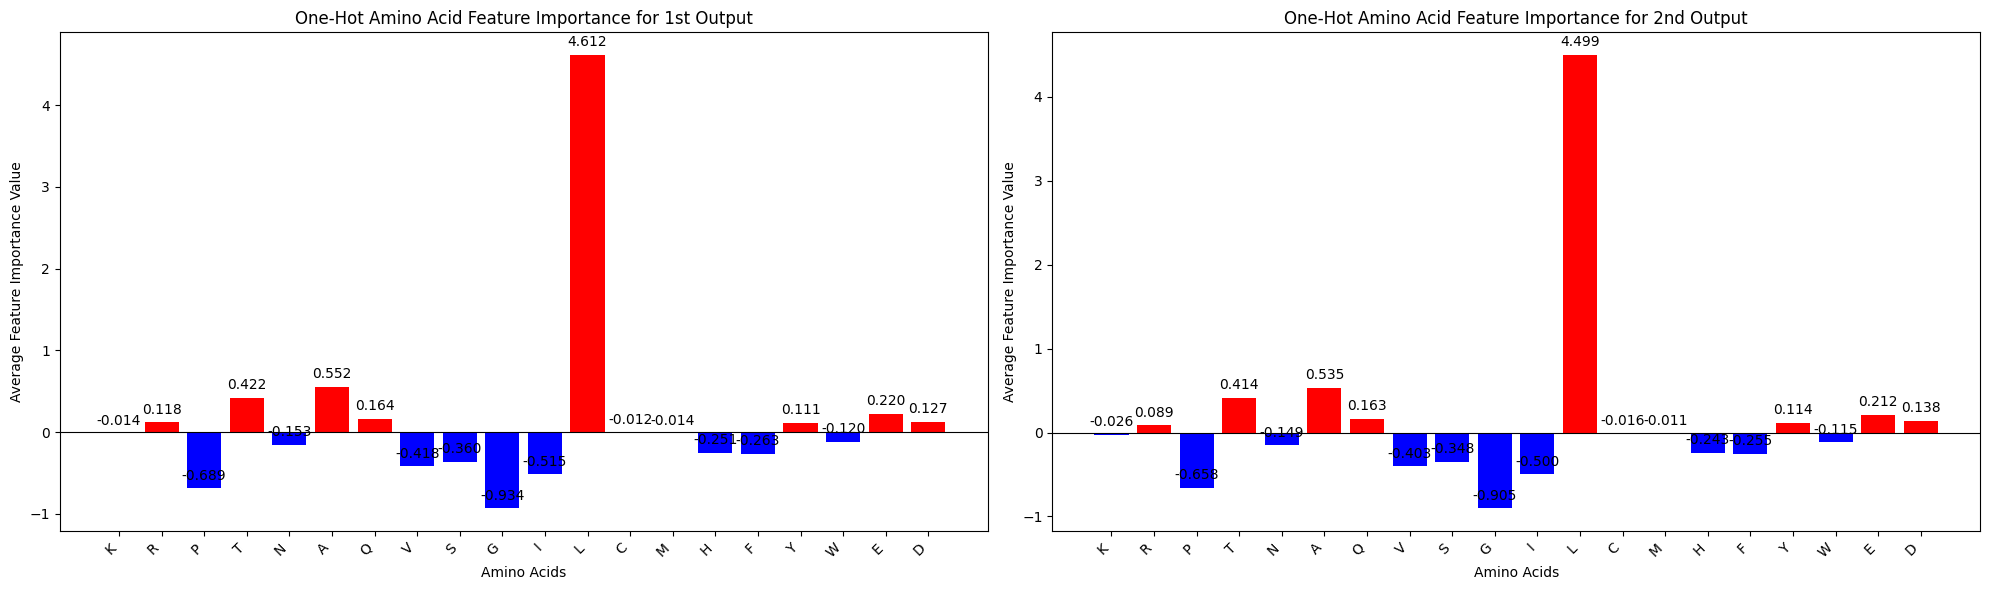

In [880]:
def plot_amino_acids_shap(amino_acids, values, title, ax):
    # Colors based on the value
    colors = ['red' if x > 0 else 'blue' for x in values]

    # Create the bar plot for the given amino acid SHAP values
    bars = ax.bar(amino_acids, values, color=colors)
    ax.set_title(title)
    ax.set_ylabel('Average Feature Importance Value')
    ax.set_xlabel('Amino Acids')
    ax.set_xticklabels(amino_acids, rotation=45, ha='right')
    ax.axhline(0, color='black', linewidth=0.8)  # Add a line at zero for reference

    # Annotate bars with the SHAP values
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 4),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Setup plots
fig, axs = plt.subplots(ncols=2, figsize=(20, 6))

# Generate bar plots
plot_amino_acids_shap(amino_acids, amino_acids_mean1, 'One-Hot Amino Acid Feature Importance for 1st Output', axs[0])
plot_amino_acids_shap(amino_acids, amino_acids_mean2, 'One-Hot Amino Acid Feature Importance for 2nd Output', axs[1])

plt.tight_layout()
plt.show()